# Classification with Naive Bayes

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Bphi}{\boldsymbol{\mathsf{\phi}}}$
$\newcommand{\BPhi}{\boldsymbol{\Phi}}$
$\newcommand{\Cond}{\,|\,}$
$\newcommand{\DNorm}[3]{\mathcal{N}(#1\Cond#2, #3)}$
$\newcommand{\DUniform}[3]{\mathcal{U}(#1 \Cond #2, #3)}$
$\newcommand{\Ex}[2][]{\mathbb{E}_{#1} \left[ #2 \right]}$
$\newcommand{\var}[1]{\operatorname{var}[#1]}$
$\newcommand{\cov}[1]{\operatorname{cov}[#1]}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\DeclareMathOperator*{\argmax}{arg\,max}$

In this notebook we create a Naive Bayes Classifier to predict whether an individual earns more or less than a specific amount. We compute both the Maximum Likelihood and Maximum a Posteriori parameters and evaluate the efficacy of the classifier.   

(Please evaluate this cell to activate the $\LaTeX$ macros.)

In [1]:
import csv, scipy, scipy.stats, collections, itertools
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## The data set


The data set contains census information. Our task is to predict whether an indivual earns more than some amount.

Please download the following data:
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Read and preprocess the data.

In [2]:
raw_data = np.genfromtxt("adult.data", dtype=str, delimiter=',', autostrip=True)

# targets
target = ">50K"
target_column = raw_data[:,-1]
Y = (target_column == target).reshape(-1,1)
assert any(Y) and any(~Y), set(target_column)

features = [
    'age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status', 
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
    'hours_per_week', 'native_country'
]

raw_features = raw_data[:,:-1] # drop the target
assert raw_features.shape[1] == len(features)


def preprocess_continuous(column):
    # convert continuous variables stored as strings to binary by comparing with the median
    float_column = column.astype(float)
    return (float_column > np.median(float_column)).astype(float).reshape(-1,1)


def preprocess_categorical(column):
    # convert categorical variables to indicator vectors
    values = sorted(set(column))
    if len(values) == 2:
        values = values[:1]
    return np.hstack([column.reshape(-1,1)==v for v in values]).astype(float)


preprocessor = collections.defaultdict(lambda: preprocess_categorical)
preprocessor.update(dict(
    age=preprocess_continuous, 
    fnlwgt=preprocess_continuous, 
    education_num=preprocess_continuous,
    capital_gain=preprocess_continuous, 
    capital_loss=preprocess_continuous, 
    hours_per_week=preprocess_continuous,
))

# apply appropriate preprocessor to each column of raw_features
X_list = [preprocessor[feature](raw_features[:,features.index(feature)]) for feature in features]
for feature, X in zip(features, X_list):
    assert X.shape[0] == raw_features.shape[0]
    print(X.shape[1], '\t', feature)
    
make_feature_names = lambda feature, dimension: ['%s_%.2i' % (feature, i) for i in range(dimension)]
binary_feature_names_list = [make_feature_names(feature, X.shape[1]) for feature, X in zip(features, X_list)]
binary_feature_names = list(itertools.chain(*binary_feature_names_list))

X = np.hstack(X_list)
X = X.astype(dtype = bool) # Storing X as boolean array speeds up some computations modestly (~20%).
assert set(X.flatten()) == {0.0, 1.0}
assert len(binary_feature_names) == X.shape[1]

1 	 age
9 	 workclass
1 	 fnlwgt
16 	 education
1 	 education_num
7 	 marital_status
15 	 occupation
6 	 relationship
5 	 race
1 	 sex
1 	 capital_gain
1 	 capital_loss
1 	 hours_per_week
42 	 native_country


Plot the data.


X.shape 	 (32561, 107)
Y.shape 	 (32561, 1)

mean(Y) 0.240809557446


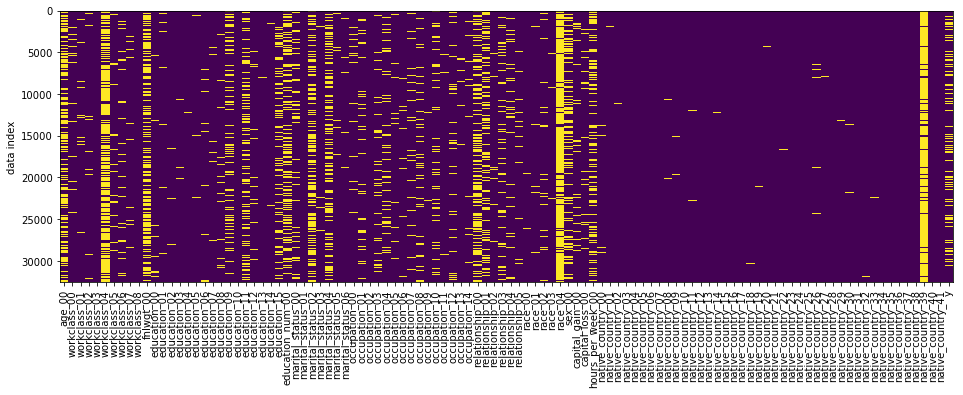

In [3]:
print('')
print('X.shape', '\t', X.shape)
print('Y.shape', '\t', Y.shape)
print()
print('mean(Y)', np.mean(Y))

figure = lambda : plt.figure(figsize=(16,5))
figure()
plt.imshow(np.hstack((X,Y)))
plt.axis('auto')
plt.ylabel('data index');
plt.gca().set_xticks(list(range(X.shape[1]+1)))
plt.gca().set_xticklabels(binary_feature_names+['y'], rotation='vertical')

ntrain = 1200
ishuffle = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(ishuffle)
itrain = ishuffle[slice(0,ntrain)]
itest = ishuffle[slice(ntrain,None)]
X_train, Y_train = X[itrain,:], Y[itrain,:]
X_test, Y_test = X[itest,:], Y[itest,:]

## 1A: Naive Bayes: Maximum Likelihood (m.l.)
Assume we have dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ where $\mathbf{x}_i\in\{0,1\}^d$, $y_i\in\{0,1\}$, $n$ is the number of data points and $d$ the number of features.
1. State the independence assumption of the naive Bayes classifier.
- Appropriately assume Bernoulli random variables. Letting $p(x_j=1|y=k) = \rho_{j,k}$ for $k=0,1$ and $p(y=1)=\mu$, derive the maximum likelihood $\rho_{j,k}$ and $\mu$ (that is, the parameters which maximise the likelihood).
- Implement a function which computes these maximum likelihood parameters, and call it on ```X_train, Y_train```.
- Plot the $\rho_{j,k}$ (vertical) vs. $j$ (horizontal) using ```plt.plot``` with ```marker='.'```, labeling appropriately.
- Print the number of $\rho_{j,k}$ which are zero.
- Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.

### <span style="color:blue">Answer</span>

Q1. The independence assumption of the naive Bayes classifier are that the features are (conditionally on class) independent, so that the following factorisation is permitted for each data point $(\mathbf{x}, y) \in \mathcal{D}$:

$$ p\left( (x_1, x_2, \ldots, x_d, y) \ \big| \ \rho_{j,k}, \mu \right) = p( y \ | \ \mu ) \prod_{k=1}^d p( x_k \ | \ \rho_{k, y}) $$

Q2. By the naive Bayes assumption, we can factorise the likelihood as follows:

\begin{align}
p\left( \mathcal{D} \ \big| \ \rho_{j,k}, \mu \right) &= \prod_{i=1}^n \left( p(y_i \ | \ \mu) \prod_{k=1}^d p(x_{i,k} \ | \ \rho_{k, y_i} ) \right) \\
                                                  &= \prod_{i=1}^n p(y_i \ | \ \mu) \ \cdot \ \prod_{i=1}^n \left(\prod_{k=1}^d p( x_{i,k} \ | \ \rho_{k, y_i} ) \right) \\
                                                  &= \prod_{i=1}^n p(y_i \ | \ \mu) \ \cdot \  \prod_{k=1}^d \left( \prod_{i=1}^n p( x_{i,k} \ | \ \rho_{k, y_i} ) \right) \\
                                                  &= \prod_{i=1}^n p(y_i \ | \ \mu) \ \cdot \  \prod_{k=1}^d \left(\left( \prod_{i\in N} p( x_{i,k} \ | \ \rho_{k, 1} )\right) \left(\prod_{i\in \hat{N}} p( x_{i,k} \ | \ \rho_{k, 0} )\right) \ \right)
\end{align}

where $N = \{n_1, n_2, \ldots, n_t \} $ are the indicies for wihch $y_i = 1,$ and $\hat{N} = \{ 1,2,\ldots, n\}\setminus{N}$ are the indicies for which $y_i = 0.$ 

Let $r_j = \big| \{ i \in N \ | \ x_{i,j} = 1 \} \big|$ and $s_j = \big| \{ i \in \hat{N} \ | \ x_{i,j} = 1 \} \big|.$ In words, $r_j$ is the number of sample points where $y=1$ and the $j$-th feature is also $1$, and $s_j$ is the numer of sample points where $y=0$ and the $j$-th feature is $1.$ We can write the likelihood in the following form:

$$ p\left( \mathcal{D} \ \big| \ \rho_{j,k}, \mu \right) = \mu^{|N|} (1-\mu)^{n - |N|} \cdot \prod_{j=1}^d \left( \left(\rho_{j,1}^{r_j} (1-\rho_{j,1})^{|N|-r_j} \right) \left(\rho_{j,0}^{s_j} (1-\rho_{j,0})^{|\hat{N}|-s_j} \right) \right)$$

So we have written our likelihood as a product of $2d+1$ functions, each function involving just a single one of each of the $2d+1$ parameters. So the set of parameters that maximises the likelihood is the same as the parameters that maximise the component functions separately.

Each of the functions are of the same general form, so we will apply the following result to all of them:
_________________________________________
Let $Z \sim \operatorname{Bernoulli}(q)$ and $\{ z_1, \ldots, z_m \}$ be a set of $m$ i.i.d samples of $Z.$  Then (by definition of the Bernoulli distribution) we have $p( z_i \ | \ q) = q$ if $z_i = 1$ and $1-q$ if $z_i = 0.$ This can be written case free as $ p( z_i \ | \ q ) = q^{z_i} \ (1-q)^{(1 - z_i)}.$ The likelihood is given by 
$$ f(q) = \prod_{i=1}^m p ( z_i \ | \ q) = q^t (1-q)^{m-t} $$ where $t$ is the number of successes $z_i = 1$ in the sample set. To find the $q \in [0,1]$ that maximises the likelihood, we maximise $\log f(q)$ (which preserves the argmax because log is monotone increasing): 

$$ \log f(q) = t \log q + (m-t) \log (1-q) $$

Solving $\frac{d}{dq} \log f(q) = \frac{t}{q} + \frac{m-t}{q-1} = 0$ gives $ q = t/m.$ Putting $q= t/m$ into the second derivative 

\begin{align}
\frac{d^2}{dq^2} \log f(q)\bigg|_{q = t/m} &= \left(\frac{-t}{q^2} - \frac{ m-t}{(q-1)^2}\right)_{q=t/m} \\
                                           &= - m^2 \left( \frac{1}{t} + \frac{1}{m-t} \right) \\
                                           &< 0
\end{align}
so $q= t/m$ is a local maximum. Since $\lim_{q\to 0} \log f(q) = \lim_{q\to 1} \log f(q) = - \infty$, it is the global maximum. In summary, $q=t/m$ maximises the likelihood $f(q).$
_________________________________________

Applying our result over all the parameters, we have the following maximum likelihood parameters for the original likelihood function: 

$$ \mu = \frac{|N|}{n}, \ \rho_{j,1} = \frac{r_j}{|N|}, \ \rho_{j,0} = \frac{s_j}{|\hat{N}|} $$.

The maximum likelihood parameters for the Bernoulli distributions are all given by the proporition of successes in the relevant sample population, which agrees with our intuition.

Q3.

In [4]:
def ML_parameters(X, Y):
    '''
    Takes as input binary feature data X and labels Y. Assumes the
    model described in the question statement and returns ML estimates
    for the parameters.
    '''
    # As derived above,, the ML rho_{j,1}, rho{j,0} are the means of
    # the j-th column of the true samples and false samples respectively.
    rho1_ML = np.mean( X[np.where(Y)[0]] , axis=0)
    rho0_ML = np.mean( X[np.where(~Y)[0]] , axis=0)
    mu_ML = np.mean(Y)
    
    return rho0_ML, rho1_ML, mu_ML

In [5]:
rho0_ML, rho1_ML, mu_ML = ML_parameters(X_train, Y_train)

Q4.

In [6]:
def plot_rho_vs_j(rho0, rho1):
    '''
    Takes two arrays which contain estimates of rho_j,0 and rho_j,1, and plots them against j. 
    Does not return anything.
    '''
    j_axis = list(range(1, len(rho0)+1))
    
    fig = plt.figure(figsize=(45,6))
    ax = fig.add_subplot(122)
    ax.plot(j_axis, rho0, '.', label='$k=0$')
    ax.plot(j_axis, rho1, '.', label='$k=1$')
    ax.set_title('$\\rho_{j,k}$ vs $j$' )
    ax.legend(loc='best')
    ax.grid()
    ax.set_ylabel('$y$')
    ax.set_xlabel(r'$j$')

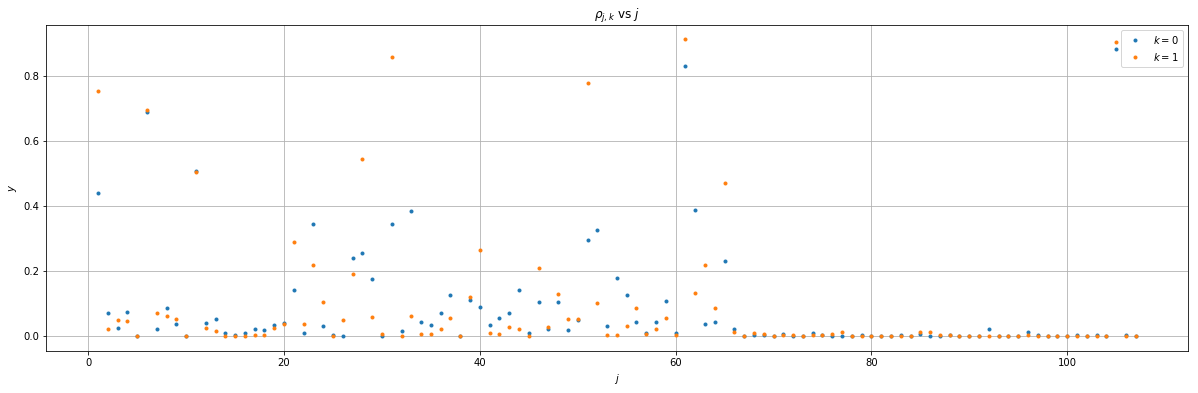

In [7]:
plot_rho_vs_j(rho0_ML, rho1_ML)

Q5. From the ML estimates, the number of $\rho_{j,k}$ which are zero is printed below.

In [8]:
print(len(np.where(rho0_ML == 0)[0]) + len(np.where(rho1_ML == 0)[0]))

51


Q6. Suppose that $\rho_{j,k} = 0,$ which means that in our training samples with $y=k,$ the $j$-th feature happened to always be 0. In the future, when we see a new sample $(x_1, \ldots, x_d)$ and want to make a prediction $p( y=k \ | \ (x_1, \ldots, x_d) ),$ the numerator (we do the full computation in 1D1 of this assignment) will involve a product with $\rho_{j,k}$ as one of the terms. This means that every single time we see $x_j = 1,$ we will never predict $y=k$ no matter how overwhelming all the other features give evidence to the contrary. This is usually undesirable because unless we have good reason to believe that one particular feature should wield so much deterministic power compared to every other feature, we should always allow for all the other features to be able to possibly sway the prediction. Similarly, if $\rho_{j,k} = 1,$ then in the future if we see a sample with $x_j = 0,$ we will always predict $y = 1-k$ and never $y=k.$ 

## 1B: Naive Bayes: Maximum a Posteriori (m.a.p.)
Let $\rho_{j,k}\sim\text{Beta}(\beta)$, with p.d.f. $f_{\rho_{j,k}}(\rho)=\frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)}$ where $Z$ is a normalisation factor. Assume a uniform prior for $\mu$.
1. Derive the maximum a posteriori $\rho_{j,k}$ and $\mu$ given the above prior.
- Implement a function which computes these maximum a posteriori parameters.
- Verify with ```assert np.allclose()``` that the m.a.p. solution with $\beta=1$ is identical to the m.l. solution. 
- Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$. For each case scatter plot the m.a.p. parameters vs. the m.l. parameters, all on one axis, colored and labelled appropriately.
- Give one example of the role of $\beta$ as evidenced by the plot.

### <span style="color:blue">Answer</span>
Q1. We continue on from 1A2 where we derived the likelihood function and defined the relevant constants. As we saw, we could write our likelihood function as a product of functions each of which involve only a single one of the parameters, so it was valid to maximise each parameter separately. For the Maximum a Posteriori parameters, we need to compute $$\argmax_{\mu, \rho_{j,k}} p( \mu, \rho_{j,k} \ | \ \mathcal{D}).$$

By Bayes' theorem this is equal to $$\argmax_{\mu, \rho_{j,k}} p( \mathcal{D} \ | \ \mu, \rho_{j,k} ) \  p( \mu, \rho_{j,k}).$$ The joint distribution $p( \mu, \rho_{j,k})$ is also separable in the same way as the likelihood, so our MAP parameters can again be found by maximising the above expression over each parameter separately. 

For $\mu,$ since we assume a uniform prior distribution, the computation for the MAP estimate is essentially unchanged from the ML estimate, and we get $\mu =|N|/n$ again. 

For $\rho_{j,1}$ we assume the Beta distribution as given in the question statement, and so we compute 

\begin{align}
\argmax_{\rho_{j,1}} p( \mu, \rho_{j,k} \ | \ \mathcal{D} ) &= \argmax_{\rho_{j,1}} \rho_{j,1}^{r_j} (1- \rho_{j,1})^{|N|-r_j} \ \cdot \ \rho_{j,1}^{\beta -1} (1- \rho_{j,1})^{\beta - 1} \\
                                                            &= \argmax_{\rho_{j,1}} \rho_{j,1}^{r_j +\beta -1} (1- \rho_{j,1})^{|N|-r_j + \beta -1}
\end{align}

This is the same calculation that we did more generally in 1A2, with $t = r_j + \beta - 1$ and $m = |N| + 2\beta - 2. \ $ So by that result we get that the MAP estimate for $\rho_{j,1}$ is 

$$ \rho_{j,1} = \frac{ r_j + \beta -1}{|N| + 2\beta -2} .$$

Similarly we have the MAP estimate for $\rho_{j,0}:$

$$ \rho_{j,0} = \frac{ s_j + \beta -1}{|\hat{N}| + 2\beta -2}.$$

Q2.

In [9]:
def MAP_parameters(X, Y, beta):
    '''
    Takes as input binary feature data X, labels Y and real beta >= 1.
    Assumes the model described in the question statement and returns
    MAP estimates for the parameters.
    '''
    # As derived above, the MAP parameters are the means of the columns
    # with an adjustment applied to the numerator and denominator.
    
    rho1_numerators = np.sum( X[np.where(Y)[0]] , axis=0) + beta - 1
    rho1_MAP = rho1_numerators/(len(np.where(Y)[0]) + 2 * beta - 2)
    
    rho0_numerators = np.sum( X[np.where(~ Y)[0]] , axis=0) + beta - 1
    rho0_MAP = rho0_numerators/(len(np.where(~ Y)[0]) + 2 * beta - 2)
    
    mu_MAP = np.mean(Y)
    
    return rho0_MAP, rho1_MAP, mu_MAP

Q3.

In [10]:
rho0_MAP, rho1_MAP, mu_MAP = MAP_parameters(X_train, Y_train, beta = 1)

assert np.allclose(rho0_MAP, rho0_ML)
assert np.allclose(rho1_MAP, rho1_ML)
assert np.allclose(mu_MAP, mu_ML)

Q4.

In [11]:
def plot_rhoML_rhoMAP_vs_j(beta):
    '''
    Takes a real beta => 1 as input and plots the ML estimates
    and MAP (prior distribution with parameter beta) against j.
    Does not return anything.
    '''
    rhoML0, rhoML1, muML = ML_parameters(X_train, Y_train)
    rhoMAP0, rhoMAP1, muMAP = MAP_parameters(X_train, Y_train, beta)
    
    j_axis = list(range(1, len(rhoML0)+1))
    
    fig = plt.figure(figsize=(45,11))
    ax = fig.add_subplot(122)
    ax.plot(j_axis, rhoML0, 'b.', label='ML, $k=0$')
    ax.plot(j_axis, rhoML1, 'g.', label='$ML, k=1$')
    ax.plot(j_axis, rhoMAP0, 'r.', label='$MAP, k=0$')
    ax.plot(j_axis, rhoMAP1, 'y.', label='$MAP, k=1$')
    ax.set_title('$\\rho_{ML}$ and $\\rho_{MAP}$ ($\\beta=$ %s) vs $j$' % beta )
    ax.legend(loc='best')
    ax.grid()
    ax.set_ylabel('$y$')
    ax.set_xlabel(r'$j$')

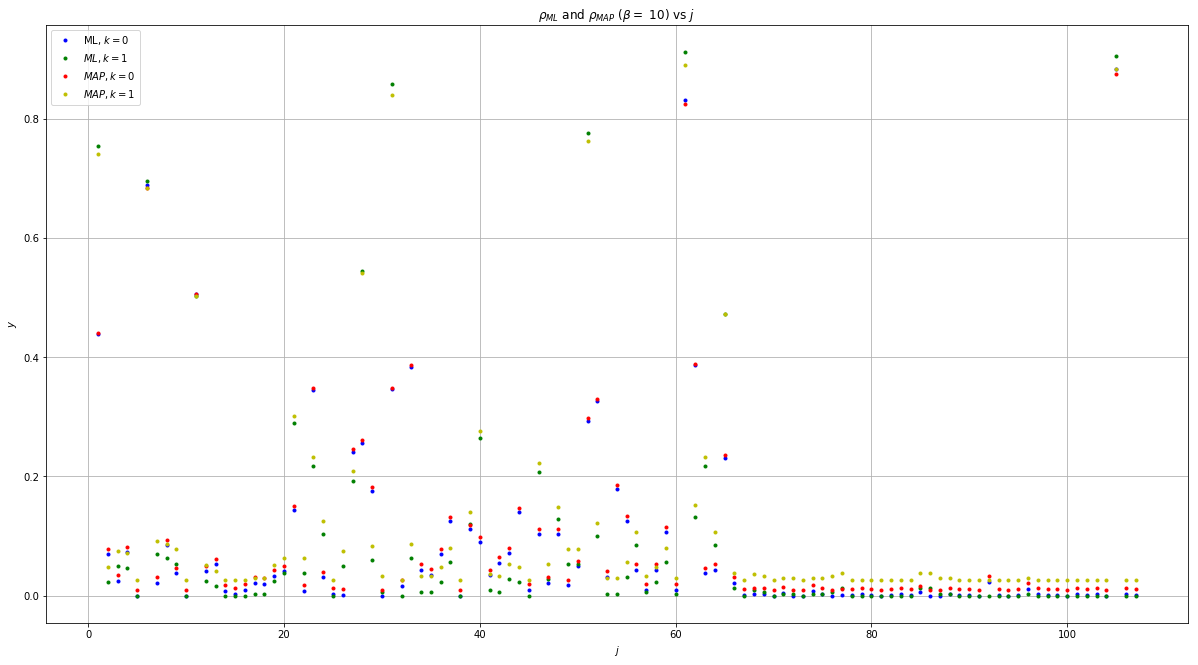

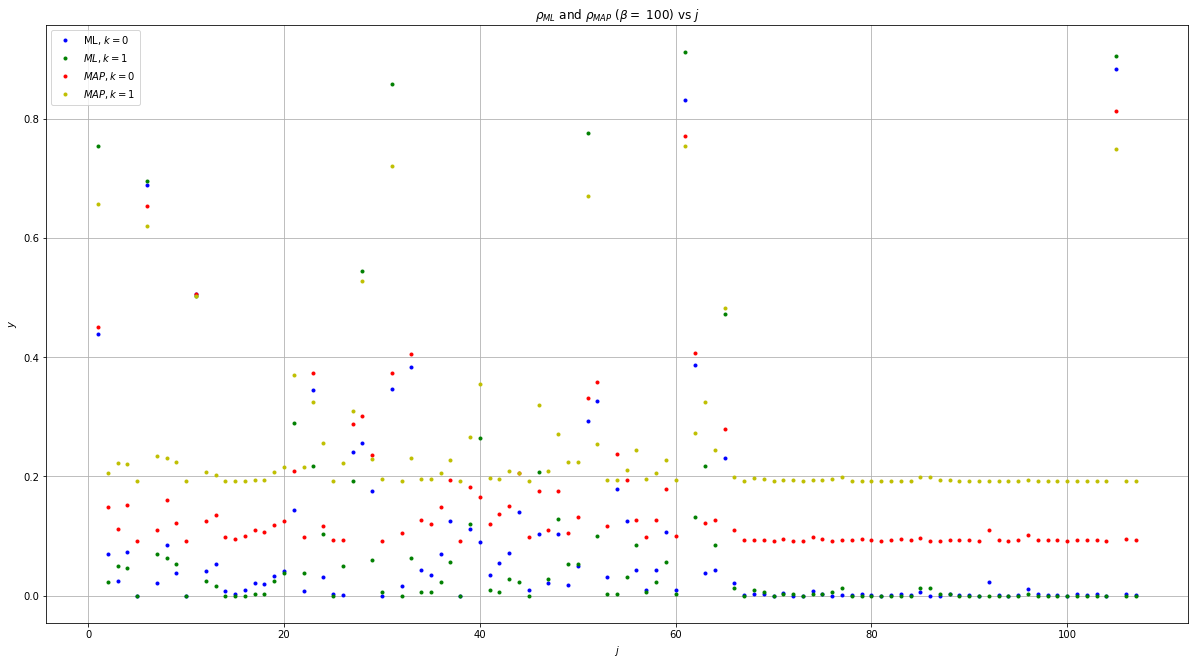

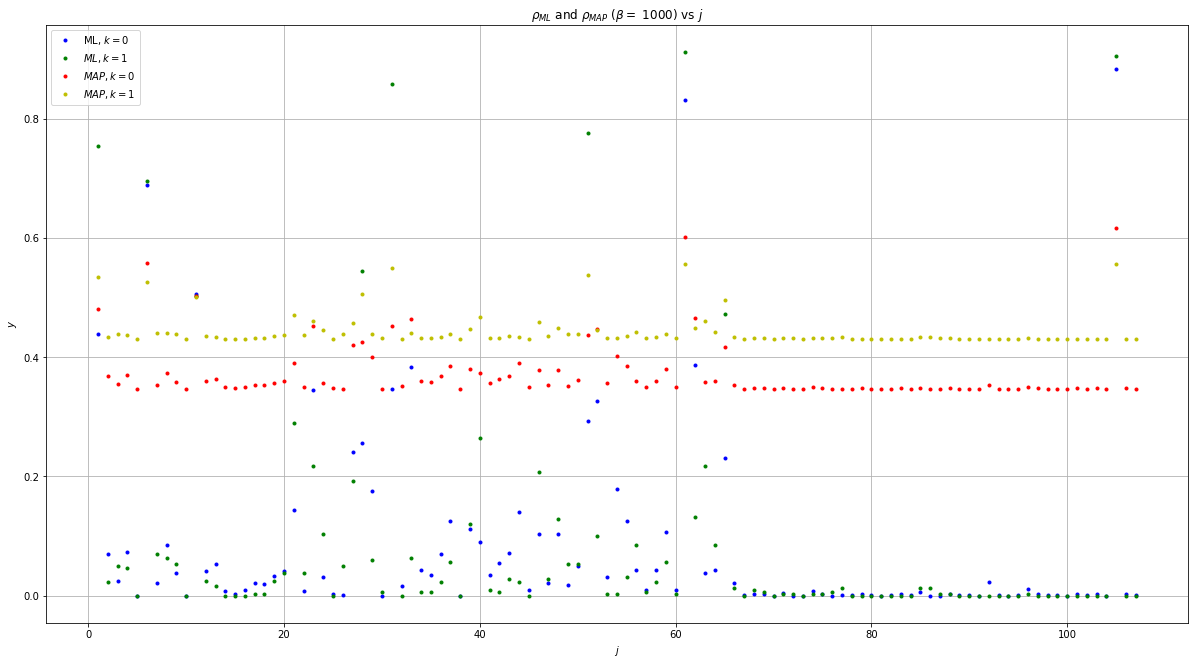

In [12]:
plot_rhoML_rhoMAP_vs_j(beta = 10)
plot_rhoML_rhoMAP_vs_j(beta = 100)
plot_rhoML_rhoMAP_vs_j(beta = 1000)

Q5. Beta acts as a force to push the $\rho_{j,k}$ towards $1/2.$ As $\beta \to \infty,$ $\rho_{j,k} \to 1/2.$ In fact, for each fixed $j,k$, we can interpret the action of the prior distribution as adding in $\beta - 1$ samples to each of the $x_j = 0$ and $x_j=1$ populations in the set of samples with $y = k.$ The ML estimates for the imagined scenario are the same as the MAP estimates with the beta distribution as the prior. 

Thus, setting $\beta >1$ resolves the issue we saw arise in 1A6 - none of the $\rho_{j,k}$ will be zero (this can be seen either directly from the equations we derived, or from the interpretation as adding in samples - our model acts as if it has seen every situation at least $\beta - 1$ times).

## 1C: Naive Bayes: Prediction
1. Derive the log predictive distribution $\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)$. Where appropriate, implement this by adding log probabilities instead of multiplying probabilities. Use ```np.logaddexp``` to add probabilities stored in log space.
- Call the above funcion on ```X_test``` using m.a.p. parameters computed with $\beta=2$.
- Plot a histogram of the probabilities (use ```np.exp``` on the log probabilities) using ```plt.hist``` with ```normed=True,histtype='step',label='your_label'```. Do this for the predictive test probabilities corresponding to ```Y_test==1``` and ```Y_test==0```, puting the histograms on the same plot, labeling appropriately.

### <span style="color:blue">Answer</span>
Q1. Since $\{ \rho_{j,k} \}, \mu$ are now considered fixed parameters (given by e.g. MAP estimates) in the log predictive distribution we can stop carrying them everywhere in our notation. By Bayes' theorem and the naive Bayes' independence assumption we have 
\begin{align}
p( y=1 \ | \ (x_1, x_2, \ldots, x_d) ) &= \frac{ p( (x_1, x_2, \ldots, x_d) \ | \ y=1 ) \ p(y=1) }{ p( (x_1, x_2, \ldots, x_d) \ | \ y=1 ) \ p(y=1) +  p( (x_1, x_2, \ldots, x_d) \ | \ y=0 ) \ p(y=0) } \\
                                       &= \frac{ \mu \displaystyle\prod_{j=1}^d \left( \rho_{j,1}^{x_j} \ (1-\rho_{j,1})^{(1-x_j)} \right) }{ \mu \displaystyle\prod_{j=1}^d \left(\rho_{j,1}^{x_j} \ (1-\rho_{j,1})^{(1-x_j)} \right) + (1-\mu) \displaystyle\prod_{j=1}^d \left(\rho_{j,0}^{x_j} \ (1-\rho_{j,0})^{(1-x_j)} \right) }
\end{align}

Let
\begin{align}
\tau_1 :&= \log( p( (x_1, x_2, \ldots, x_d) \ | \ y=1 ) \ p(y=1) ) \\
       &= \log \mu + \sum_{j=1}^d \left(x_j \log( \rho_{j,1}) + (1-x_j) \log(1-\rho_{j,1}) \right)
\end{align}

and 

\begin{align}
\tau_0 :&= \log( p( (x_1, x_2, \ldots, x_d) \ | \ y=0 ) \ p(y=0) ) \\
       &= \log (1-\mu) + \sum_{j=1}^d \left(x_j \log( \rho_{j,0}) + (1-x_j) \log(1-\rho_{j,0}) \right).
\end{align}

Then the log predictive distribution can be calculated as 
\begin{align}
\log p(y=1 \ | \ (x_1, x_2,\ldots, x_d) ) &= \log \left( \frac{ \exp(\tau_1) }{\exp(\tau_1) + \exp(\tau_0)} \right) \\
                                          &= \tau_1 - \log \left( \exp(\tau_1) + \exp(\tau_0) \right)
\end{align}

In [13]:
def log_distribution(X, rho0, rho1, mu):
    '''
    Takes an array of samples X and values for the models parameters as input.
    Returns an array containing the log probability of y=1 for each of those 
    samples using the formula derived above.
    '''
    tau1 = np.log(mu) + np.sum( np.multiply(X, np.log(rho1)) + np.multiply(~X, np.log(1-rho1) ), axis=1)
    tau0 = np.log(1 - mu) + np.sum( np.multiply(X, np.log(rho0)) + np.multiply(~X, np.log(1-rho0) ), axis=1)
    
    return tau1 - np.logaddexp(tau0, tau1)

Q2.

In [14]:
log_probs = log_distribution(X_test, *MAP_parameters(X_train, Y_train, beta = 2))

Q3.

In [15]:
def plot_prediction_hist():
    '''
    Plots a histogram giving the relative frequencies of the various 
    confidence levels when predicting Y==1 or Y==0.
    '''
    probs1 = np.exp(log_probs)
    probs0 =1 - probs1

    predict_y1 = probs1[np.where(Y_test==1)[0]]
    predict_y0 = probs0[np.where(Y_test==0)[0]]

    histogram= plt.figure(figsize=(15,8))

    plt.hist(predict_y1, normed=1, histtype='step', label='Y==1')
    plt.hist(predict_y0, normed=1, histtype='step', label='Y==0')
    plt.legend(loc='upper left')
    plt.xlabel('Prediction confidence')
    plt.ylabel('Relative Frequency (% /10)')
    plt.title(r'$\mathrm{Histogram\ of\ Prediction \ Confidences \ in \ testing \ set:}\ Y=1,\ Y=0$')
    plt.show()

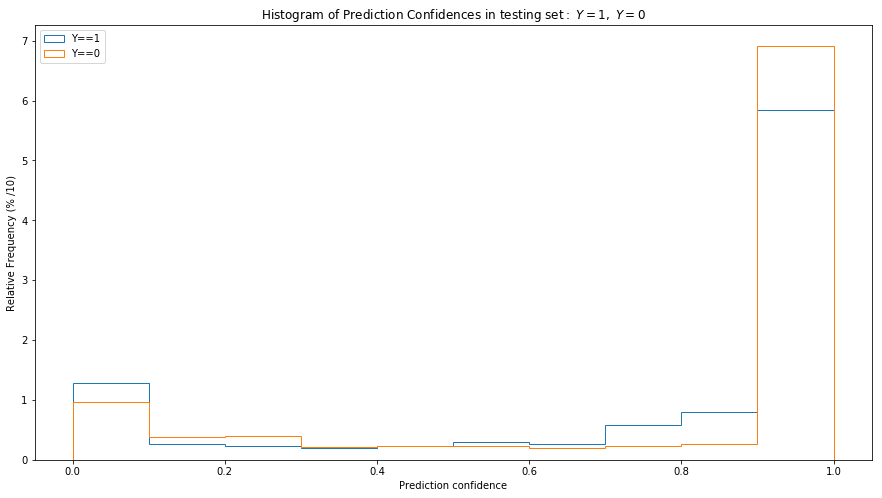

In [16]:
plot_prediction_hist()

## 1D: Naive Bayes: Evaluation
1. Write a function ```evaluate``` which takes data ```X,Y``` and model parameters $\rho_{j,k}$ and $\mu$, and returns a dict with keys ```mean_logp_true``` (for the mean predictive log probability of the ground truth labels ```Y``` given the data matrix ```X``` and ```percent_correct``` (for the percent correctly classified, assuming we classify each datum into the class with maximum predictive probability).
- Write a function ```cross_validate(beta, nfolds, X, Y)``` which performs cross validation with ```nfolds``` folds, for hyper parameter $\beta$. For each split, call your ```evaluate``` function, and return a ```dict``` with averaged results for each evaluation metric. You can make use of our ```xval_inds``` function.
- For $\beta$ in ```np.logspace(np.log10(2),2,32)``` compute the evaluation metrics on the test set, ```X_test, Y_test```, as well as the cross-validated estimates. Make one plot for each metric, showing both results on each (for a total of four curves). Label appropriately.

### <span style="color:blue">Answer</span>
Q1.

In [17]:
def evaluate(X, Y, rho0, rho1, mu):
    
    Y1_logp = log_distribution(X, rho0, rho1, mu)
    Y1_probs = np.exp(Y1_logp)
    
    Y0_probs = 1 - Y1_probs
    Y0_logp = np.log(Y0_probs)
    
    # We predict Y==1 if Y1_probs => 1/2 and Y==0 otherwise.
    # So the prediction for Y is Y1_probs rounded to nearest integer.
    percent_correct = 100 * np.mean(Y.T == np.around(Y1_probs))

    # Sum the log probabilities calculated for the ground truth label.
    sum_logp_1 = np.sum(Y1_logp[np.where(Y)[0]])
    sum_logp_0 = np.sum(Y0_logp[np.where(~Y)[0]])
    
    mean_logp_true = (sum_logp_1 + sum_logp_0)/len(Y)
    
    return { 'mean_logp_true' : mean_logp_true, 'percent_correct' : percent_correct}

In [18]:
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))

Q2.

In [19]:
def cross_validate(beta, nfolds, X, Y):
    '''
    Takes real beta >= 1, an integer nfolds and data X, Y as inputs.
    
    Performs n-fold cross validation. Training is done by computing MAP parameters 
    with beta as the parameter in the prior distribution. We measure our accuracy by calling 'evaluate'
    and returning a dictionary with the average results over the nfolds. 
    '''
    percent_correct_sum = 0
    mean_logp_true_sum = 0
    
    for train_index, test_index in xval_inds(len(Y), nfolds):
        eval_dict = evaluate(X[test_index], Y[test_index], *MAP_parameters(X[train_index], Y[train_index], beta))
        percent_correct_sum += eval_dict['percent_correct']
        mean_logp_true_sum  += eval_dict['mean_logp_true']
        
    return { 'mean_logp_true' : mean_logp_true_sum/nfolds, 'percent_correct': percent_correct_sum/nfolds }

Q3.

In [20]:
def plot_metrics_vs_beta(nfolds):
    '''
    Takes integer nfolds as input.
    Returns the plots described in the question statement.
    Cross validation is done with nfolds folds.
    '''
    assert len(Y_train) % nfolds == 0
    # Collect metric measures over the range of beta.
    beta_axis = np.logspace(np.log10(2),2,32)
    eval_percent = []
    eval_mean_logp_true = []
    cv_percent = []
    cv_mean_logp_true = []
    
    for beta in beta_axis:
        eval_dict = evaluate(X_test, Y_test, *MAP_parameters(X_train, Y_train, beta))
        
        eval_percent.append(eval_dict['percent_correct'])
        eval_mean_logp_true.append(eval_dict['mean_logp_true'])
        
        cv_dict = cross_validate(beta, nfolds, X_train, Y_train)
        
        cv_percent.append(cv_dict['percent_correct'])
        cv_mean_logp_true.append(cv_dict['mean_logp_true'])
    
    # Plot percent_correct against beta (ideal result is near 100)
    fig_percent = plt.figure(figsize=(30,9))
    ax = fig_percent.add_subplot(122)
    ax.plot(beta_axis, cv_percent,'b-', label='CV estimate')
    ax.plot(beta_axis, eval_percent,'r-', label='Evaluated on Test set')
    ax.set_title('Percent of Predictions correct vs $\\beta$')
    ax.legend(loc='best')
    ax.grid()
    ax.set_ylabel('Percent Correct')
    ax.set_xlabel(r'$\beta$')
    
    # Plot mean log propbability for true class (ideal result is near 0)
    fig_mean_logp_true = plt.figure(figsize=(30,9))
    bx = fig_mean_logp_true.add_subplot(122)
    bx.plot(beta_axis, cv_mean_logp_true,'b-', label='CV estimate')
    bx.plot(beta_axis, eval_mean_logp_true,'r-', label='Evaluated on Test set')
    bx.set_title('Mean log probability of true class vs $\\beta$ ' )
    bx.legend(loc='best')
    bx.grid()
    bx.set_ylabel('Mean log probability of true class')
    bx.set_xlabel(r'$\beta$')

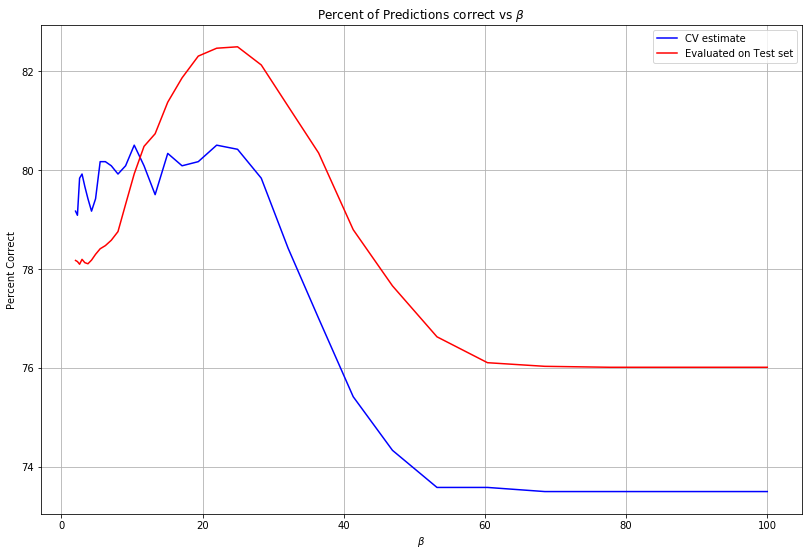

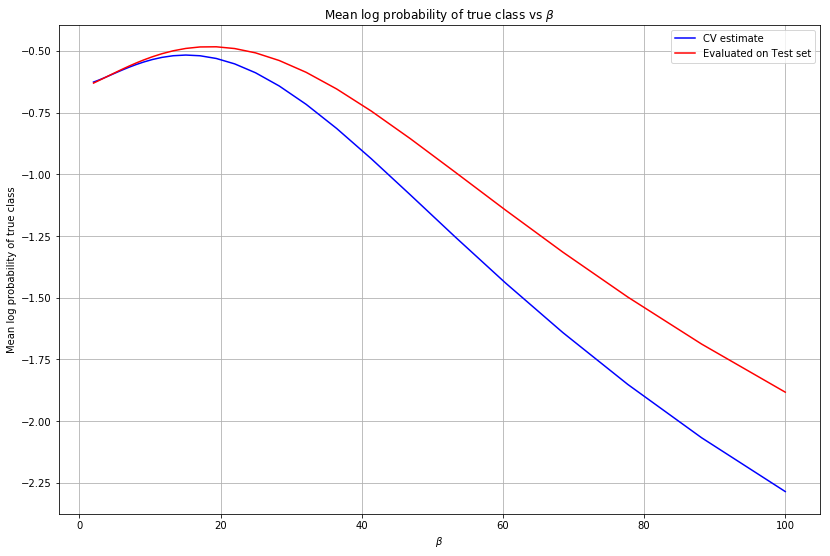

In [21]:
plot_metrics_vs_beta(10)

## 1E: Naive Bayes: Discussion
1. Explain the shortcomings of our preprocessing of (a) continous variables, and (b) categorical variables. Make note of the assumptions of our model.
- Suggest improvements to our data processing pipeline, both in terms of the representation and the model.
- Consider the distribution $p(a,b,c)$ where all three variables are binary. How many parameters are needed to specify this distribution (a) in general and (b) if it factorises as $p(a|c)p(b|c)p(c)$?

### <span style="color:blue">Answer</span>

Q1. (a) The continuous variables are classified as 0 or 1 by comparing against the median. This loses a lot of information in the data. For example, Y = [is >50k?] could be very strongly correlated with 'hours worked'> 50 but only moderately correlated with 'hours worked' > median, and we lose the opportunity to of being able to better predict Y when we see cases with more extreme values of hours worked. 

(b) The categorical variables are turned into indicator bit vectors. For example, employment class can be "State-gov, federal-gov, self-employed, private ..." and this is expanded into a new feature for each possibility: is_state-giv :{0,1}, is_self_employed: {0,1}.... etc. 

This introduces difficulties into our model in two ways. Firstly, it introduces noise in our probabliity calculation. More features means we need more data, because now we have to multiply many probabilities related to the same original feature, and lack of accuracy in any of them will hurt performance. 

Secondly, it absolutely contradicts our models naive Bayes' assumption of independence amongst the features, because the sub-features are disjoint (only 1 of all the possibilities can be true) and two disjoint events with positive probability can not be independent. This is because the condition for independence is $p(A \cap B) = p(A) p(B)$ while that for disjoint-ness is $A\cap B = \emptyset \implies p(A\cap B)=0.$ So we lose accuracy in the step where we factorise our prediction into a product.



Q2. If we stick with the model of every feature being a Bernoulli random variable with the naive Bayes' assumption, there are still improvements we could make. For a continous variable where we expect a correlation with wage (such as age), instead of picking the median we could try to select a point that better separates between Y=0 and Y=1, by e.g. picking the point which maximises percent of correct predictions (e.g. the age X which maximises the accuracy of the simple classifier Y = [is age > X?]). 

Better yet would be to model each feature with distributions more appropriate to the feature (though this may require some domain specific knowledge). Instead of splitting a categorical variable into binary sub-features and assume the same Beta distribution prior for all the Bernoulli parameters, we could use our dataset to create statistics on the feature and give a probability mass function e.g. Employment Class: { State-gov: 0.3, federal-gov: 0.2, private: 0.4 ..}. 

We could also discard our naive Bayes' model and explore the dataset to find dependencies amongst the features (for example, we could expect that race and education level are dependent), which may improve the accuracy of our probability calculations. 

Q3. 

a) Our distribution is specified if $p(a,b,c)$ is specified for each $(a,b,c) \in \{0,1\}^3,$ so $8$ parameters is sufficient. We have only one extra constraint to help us reduce parameters, and that is that all the $8$ parameters must sum to $1$, so $7$ parameters are required to specify the distribution.

b) If we are admitted the factorisation $p(a,b,c) = p(a|c)p(b|c)p(c)$ then $5$ parameters specifying $$p(a=1),\ p(b=1),\ p(c=1),\ p(a=1|c=1),\ p(b=1|c=1)$$ are enough to determine the distribution. 

Proof: Suppose we know those 5 parameters. Then note $p(a=0) = 1 - p(a=1)$ and similarly, we can determine $p(a), p(b), p(c)$ for any $a,b,c.$ If we can determine $p(a|c)$ and $p(b|c)$ for all 8 values of $(a,b,c) \in \{0,1\}^3$ then the distribution is fully specified via the factorisation. 

We get $p(a=0|c=1) = 1-p(a=1|c=1)$ and we know $p(b=0|c=1)$ similarly. So we know $p(a|c=1), p(b|c=1)$ for all $a,b.$ Then the equation $p(a) = p(a|c=0)p(c=0) + p(a|c=1)p(c=1)$ then lets us determine $p(a|c=0).$ The analogous equation concerning $p(b)$ lets us determine $p(b|c=0).$ So now we have determined $p(a|c), p(b|c)$ for all $(a,b,c) \in \{0,1\}^3.$